<a href="https://colab.research.google.com/github/PreyPython123/Master-V24-Semiveiledet-Regresjon/blob/Databehandling-Pradeep/Bioco_Databehandling_av_ekstremverdier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lasting av nødvendige pakker og bibliotek

In [1]:
! pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190250 sha256=c092bc3b067cda13910606946b071d51f90a6e9bda2950d81b5fac501d3403a5
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


Importering av nødvendige pakker og bibliotek

In [2]:
import pandas as pd
import numpy as np
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns


from pyod.models.hbos import HBOS
from pyod.models.cblof import CBLOF

from sklearn.cluster import DBSCAN

Importering av data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Velger første kolonne med dato og tid som index
behandlet_data = pd.read_csv('/content/drive/MyDrive/MasterV24/Bioco_data/manglende_data_behandlet_bioco_data.csv',
                             header=0,
                             sep=',',
                             index_col=0)

# Formatterer index til riktig format og datatype
behandlet_data.index = pd.to_datetime(behandlet_data.index,
                                      format='%Y-%m-%d %H:%M:%S')

Mounted at /content/drive


# Undersøkelse av data før behandling for ekstreme verdier

In [4]:
behandlet_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29136 entries, 2022-10-31 17:37:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   29136 non-null  int64  
 1   EnzymeType_A2   29136 non-null  int64  
 2   EnzymeType_B    29136 non-null  int64  
 3   EnzymeType_C    29136 non-null  int64  
 4   EnzymeType_D    29136 non-null  int64  
 5   EnzymeType_E    29136 non-null  int64  
 6   RawMatPercent   29136 non-null  float64
 7   NIRfat          29136 non-null  float64
 8   NIRash          29136 non-null  float64
 9   NIRwater        29136 non-null  float64
 10  TT08            29136 non-null  float64
 11  TT20            29136 non-null  float64
 12  TT12            29136 non-null  float64
 13  Collagen        89 non-null     float64
 14  Mw              460 non-null    float64
 15  SmallMolecules  460 non-null    float64
 16  BrixAdjusted    460 non-null    float64
d

# Inspeksjon av mulige ekstremverdier

Henter prediktorer verdiene som skal undersøkes

In [5]:
# Utelukker data fra kategoriske variabler for inspeksjon
prediktor_data = behandlet_data.iloc[:, 6:-4]

# Henter ut kun verdier for undersøkelse
X = prediktor_data.values

# Informasjon om data som skal undersøkes
prediktor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29136 entries, 2022-10-31 17:37:00 to 2023-06-14 01:06:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  29136 non-null  float64
 1   NIRfat         29136 non-null  float64
 2   NIRash         29136 non-null  float64
 3   NIRwater       29136 non-null  float64
 4   TT08           29136 non-null  float64
 5   TT20           29136 non-null  float64
 6   TT12           29136 non-null  float64
dtypes: float64(7)
memory usage: 1.8 MB


## Violin plot

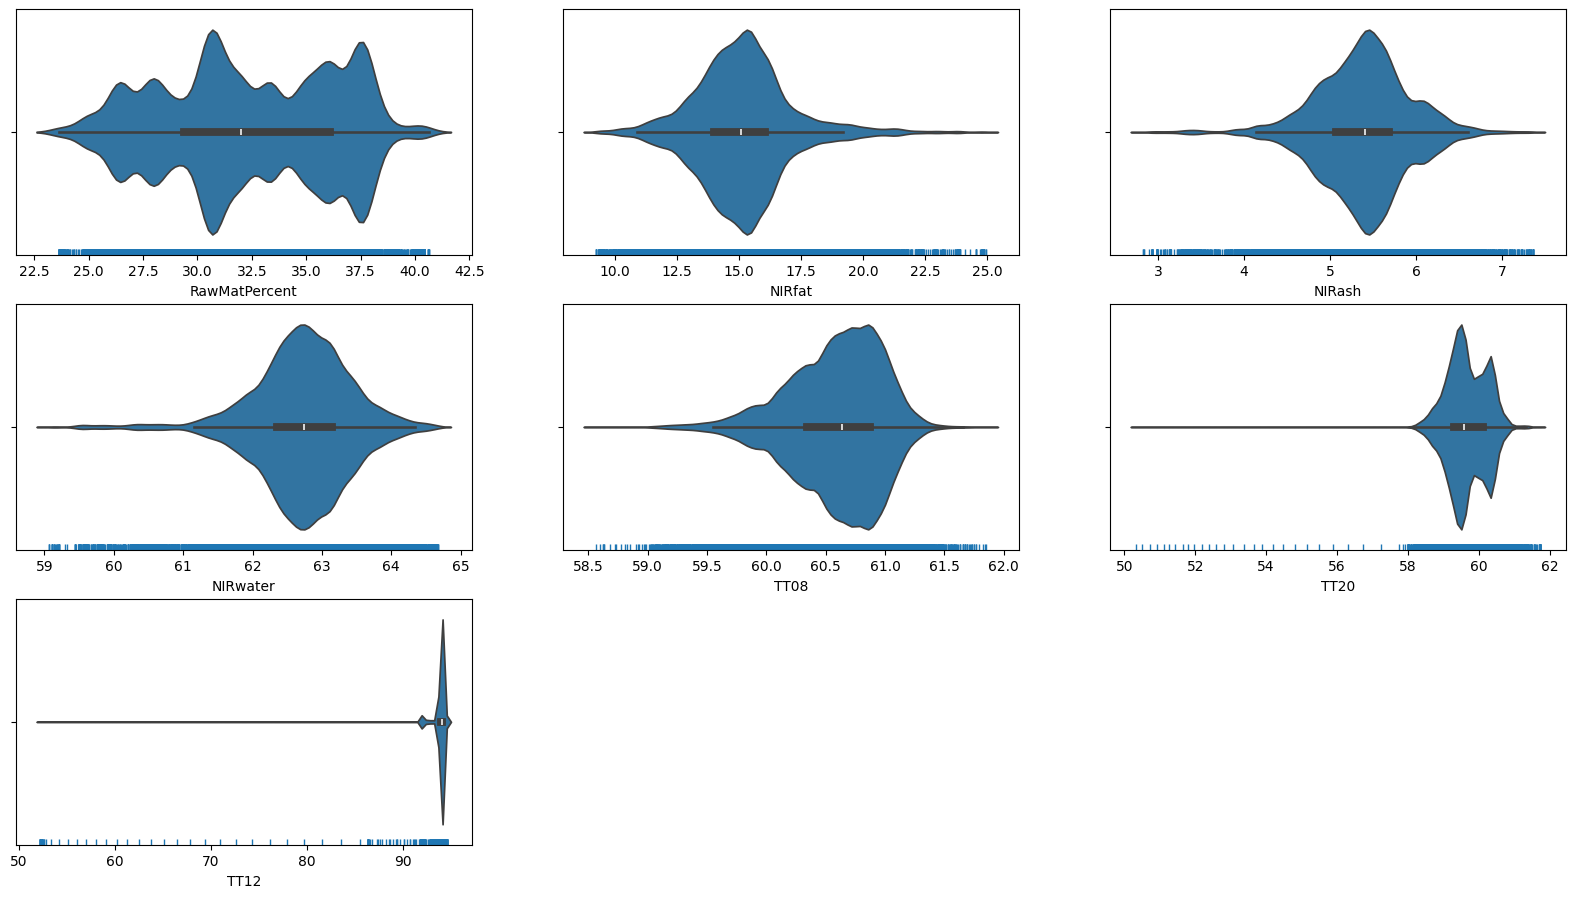

In [6]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(prediktor_data.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), prediktor_data):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = prediktor_data)
  sns.rugplot(x=prediktor_data[indeks])
  i += 1

#Ekstremverdi inspeksjon med HBOS

<ipython-input-7-4459c12e3d90>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)
<ipython-input-7-4459c12e3d90>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,2)


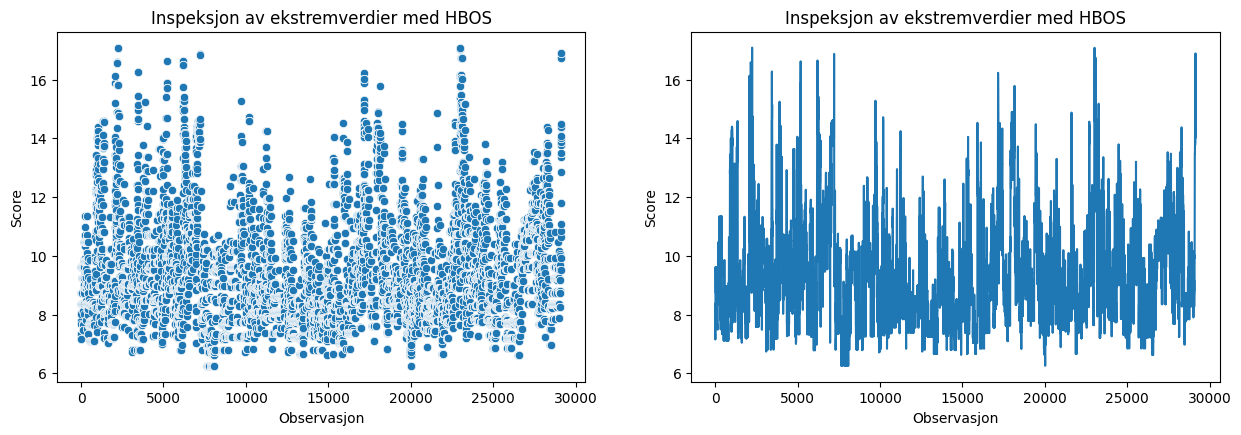

In [7]:
# Ekstremverdi inspeksjon med HBOS på data
hbos = HBOS()
hbos.fit(X)

# Predikerer mulige ekstreme observasjoner, samt score
y_predikert_hbos = hbos.labels_
y_scores_hbos = hbos.decision_scores_

# Plotter observasjoner med tilhørende score
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
plt.subplot(2,2,1)
sns.scatterplot(data=y_scores_hbos)
plt.xlabel('Observasjon')
plt.ylabel('Score')
plt.title("Inspeksjon av ekstremverdier med HBOS")

plt.subplot(2,2,2)
plt.plot(list(y_scores_hbos))
plt.xlabel('Observasjon')
plt.ylabel('Score')
plt.title("Inspeksjon av ekstremverdier med HBOS")
plt.show()

Data etter behandling av ekstremdata med HBOS

In [8]:
#Setter terskel på score som anses som ekstrem observasjon
terskel_hbos = 11

# Henter indeks til mulige ektreme observasjoner med score over terskel
mulige_ekstrem_hbos_indeks = np.where(y_scores_hbos > terskel_hbos)[0]

# Henter mulige ekstreme obersjoner over satt terskel fra data
mulige_ektrem_hbos_terskel = prediktor_data.iloc[mulige_ekstrem_hbos_indeks]

# Utelukker ekstreme observasjoner fra data
behandlet_data_hbos = prediktor_data.drop(prediktor_data.index[mulige_ekstrem_hbos_indeks])

# Data etter inspeksjon med HBOS
print("Data etter HBOS:")
print(behandlet_data_hbos.info())

Data etter HBOS:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24285 entries, 2022-10-31 17:37:00 to 2023-06-14 00:15:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  24285 non-null  float64
 1   NIRfat         24285 non-null  float64
 2   NIRash         24285 non-null  float64
 3   NIRwater       24285 non-null  float64
 4   TT08           24285 non-null  float64
 5   TT20           24285 non-null  float64
 6   TT12           24285 non-null  float64
dtypes: float64(7)
memory usage: 1.5 MB
None


Violin plot

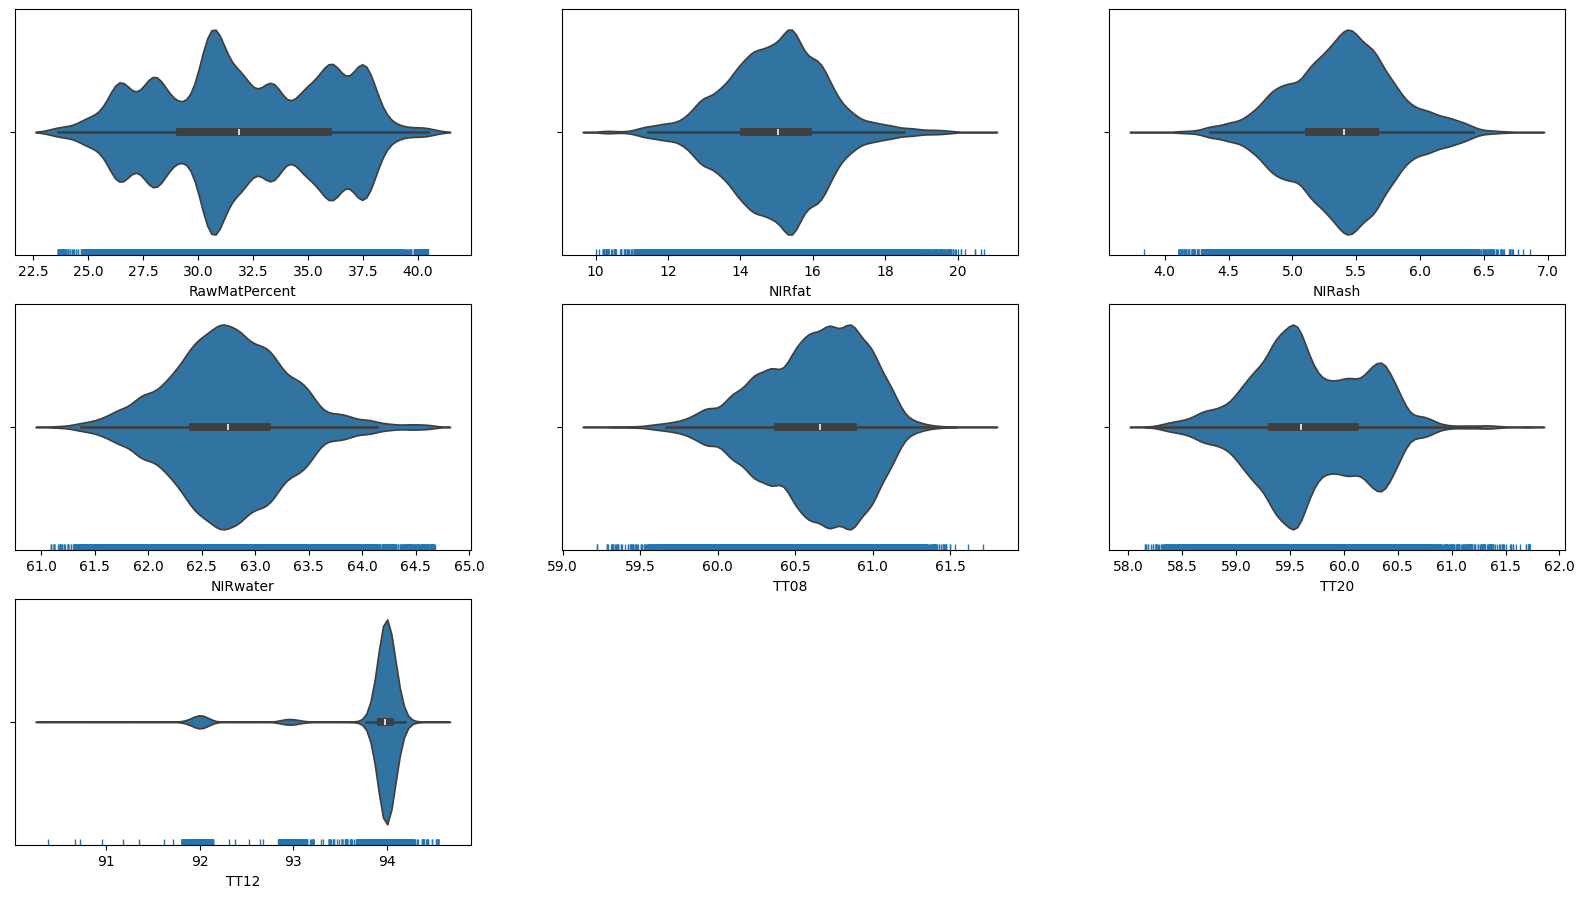

In [9]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(behandlet_data_hbos.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), behandlet_data_hbos):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = behandlet_data_hbos)
  sns.rugplot(x=behandlet_data_hbos[indeks])
  i += 1

# Ekstremsverdi inspeksjon med CBLOF

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-10-49a01b1d3dad>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)
<ipython-input-10-49a01b1d3dad>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,2)


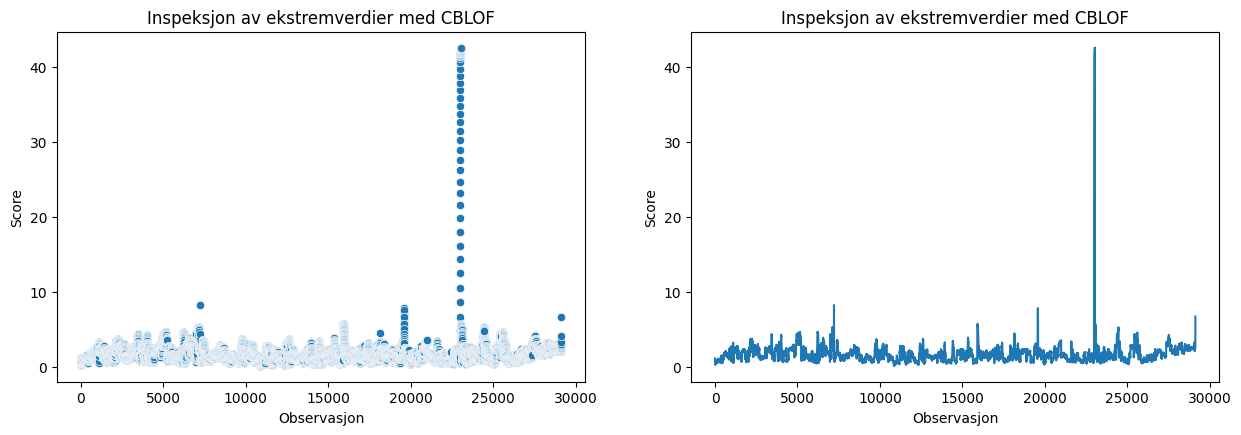

In [10]:
# Ektremverdiinspeksjon med CBLOF på data
cblof = CBLOF()
cblof.fit(X)

# Predikerer mulige ekstreme observasjoner, samt score
y_predikert_cblof = cblof.labels_
y_scores_cblof = cblof.decision_scores_

# Plotter observasjoner med tilhørende score
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
plt.subplot(2,2,1)
sns.scatterplot(data=y_scores_cblof)
plt.xlabel('Observasjon')
plt.ylabel('Score')
plt.title("Inspeksjon av ekstremverdier med CBLOF")

plt.subplot(2,2,2)
plt.plot(list(y_scores_cblof))
plt.xlabel('Observasjon')
plt.ylabel('Score')
plt.title("Inspeksjon av ekstremverdier med CBLOF")
plt.show()

Data etter behandling av ekstrem data med CBLOF

In [11]:
#Setter terskel på score som anses som ekstrem observasjon
terskel_cblof = 3
#4

# Henter indeks til mulige ektreme observasjoner med score over terskel
mulige_ekstrem_cblof_indeks = np.where(y_scores_cblof > terskel_cblof)[0]

# Henter mulige ekstreme obersjoner over satt terskel fra data
mulige_ektrem_cblof_terskel = prediktor_data.iloc[mulige_ekstrem_cblof_indeks]

# Utelukker ekstreme observasjoner fra data
behandlet_data_cblof = prediktor_data.drop(prediktor_data.index[mulige_ekstrem_cblof_indeks])

# Data etter inspeksjon med CBLOF
print("Data etter CBLOF:")
print(behandlet_data_cblof.info())

Data etter CBLOF:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27049 entries, 2022-10-31 17:37:00 to 2023-06-14 01:02:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  27049 non-null  float64
 1   NIRfat         27049 non-null  float64
 2   NIRash         27049 non-null  float64
 3   NIRwater       27049 non-null  float64
 4   TT08           27049 non-null  float64
 5   TT20           27049 non-null  float64
 6   TT12           27049 non-null  float64
dtypes: float64(7)
memory usage: 1.7 MB
None


Violin plot

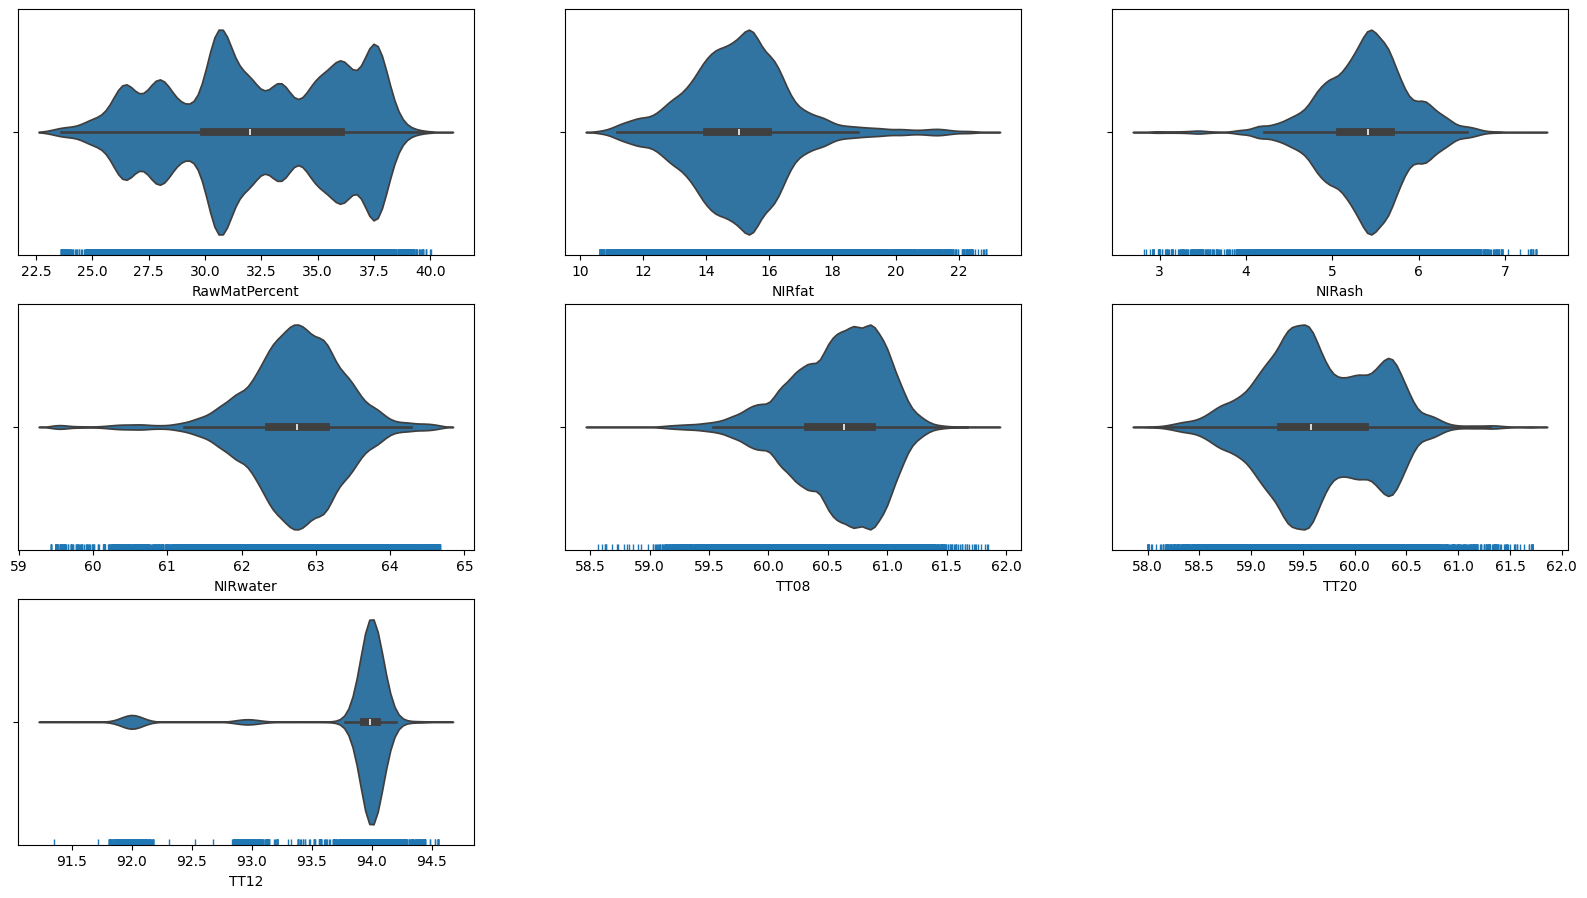

In [12]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(behandlet_data_cblof.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), behandlet_data_cblof):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = behandlet_data_cblof)
  sns.rugplot(x=behandlet_data_cblof[indeks])
  i += 1

# Ekstremverdi inspeksjon med DBSCAN

<ipython-input-13-568e5a0f3b96>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)
<ipython-input-13-568e5a0f3b96>:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,2)


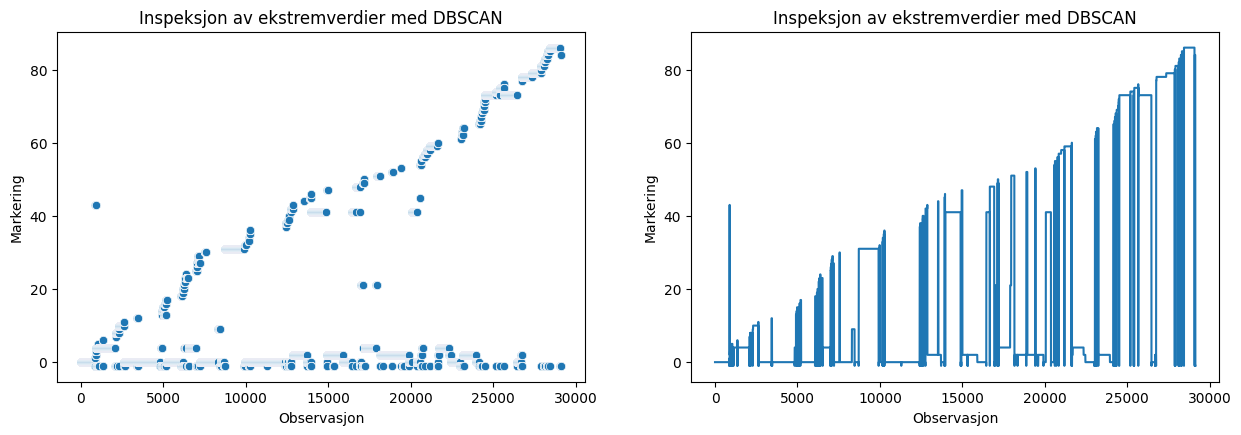

In [13]:
# Parametere for DBSCAN
eps = 0.5
min_observasjoner = 10

# DBSCAN modell
dbscan_model = DBSCAN(eps=eps, min_samples=min_observasjoner)
dbscan_model.fit(X)

# Henter labels, -1 markert som ekstrem observasjon
y_predikert_dbscan = dbscan_model.labels_

# Plotter observasjoner med tilhørende score
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
plt.subplot(2,2,1)
sns.scatterplot(data=y_predikert_dbscan)
plt.xlabel('Observasjon')
plt.ylabel('Markering')
plt.title("Inspeksjon av ekstremverdier med DBSCAN")

plt.subplot(2,2,2)
plt.plot(list(y_predikert_dbscan))
plt.xlabel('Observasjon')
plt.ylabel('Markering')
plt.title("Inspeksjon av ekstremverdier med DBSCAN")
plt.show()

In [14]:
mulige_ekstrem_dbscan_indeks = np.where(y_predikert_dbscan == -1)[0]

# Filtrerer bort ekstreme observasjoner
behandlet_data_dbscan = prediktor_data[y_predikert_dbscan != -1]

# Data etter inspeksjon med HBOS
print("Data etter DSCAN:")
print(behandlet_data_dbscan.info())

Data etter DSCAN:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28350 entries, 2022-10-31 17:37:00 to 2023-06-14 00:58:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  28350 non-null  float64
 1   NIRfat         28350 non-null  float64
 2   NIRash         28350 non-null  float64
 3   NIRwater       28350 non-null  float64
 4   TT08           28350 non-null  float64
 5   TT20           28350 non-null  float64
 6   TT12           28350 non-null  float64
dtypes: float64(7)
memory usage: 1.7 MB
None


Violin plot

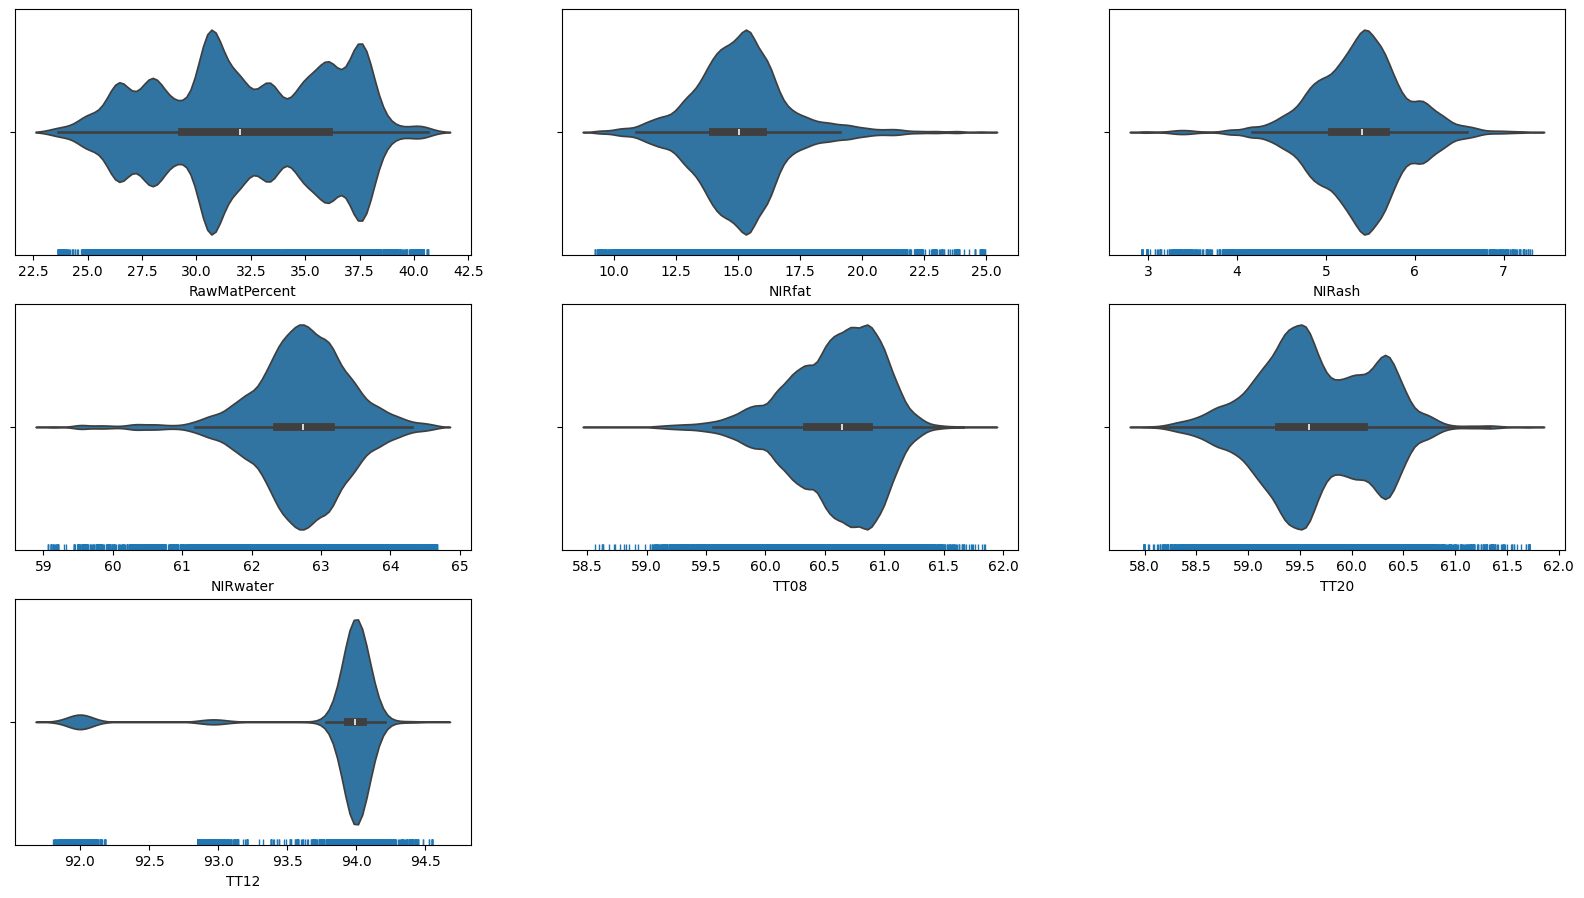

In [15]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(behandlet_data_dbscan.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), behandlet_data_dbscan):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = behandlet_data_dbscan)
  sns.rugplot(x=behandlet_data_dbscan[indeks])
  i += 1

# Samlet behandling for ekstrem data

In [16]:
# Finner ektreme observasjoner som er felles for inspeksjonene
samlet_ekstrem_indeks = np.intersect1d(mulige_ekstrem_hbos_indeks, mulige_ekstrem_cblof_indeks)

samlet_ekstrem_indeks = np.intersect1d(samlet_ekstrem_indeks, mulige_ekstrem_dbscan_indeks)


# Ekskluderer ektrem data fra original data med forklaringsvariabler
prediktor_data_ekstrem = prediktor_data.drop(prediktor_data.index[samlet_ekstrem_indeks])

# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(prediktor_data_ekstrem.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28973 entries, 2022-10-31 17:37:00 to 2023-06-14 01:02:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  28973 non-null  float64
 1   NIRfat         28973 non-null  float64
 2   NIRash         28973 non-null  float64
 3   NIRwater       28973 non-null  float64
 4   TT08           28973 non-null  float64
 5   TT20           28973 non-null  float64
 6   TT12           28973 non-null  float64
dtypes: float64(7)
memory usage: 1.8 MB
None


Violin plot

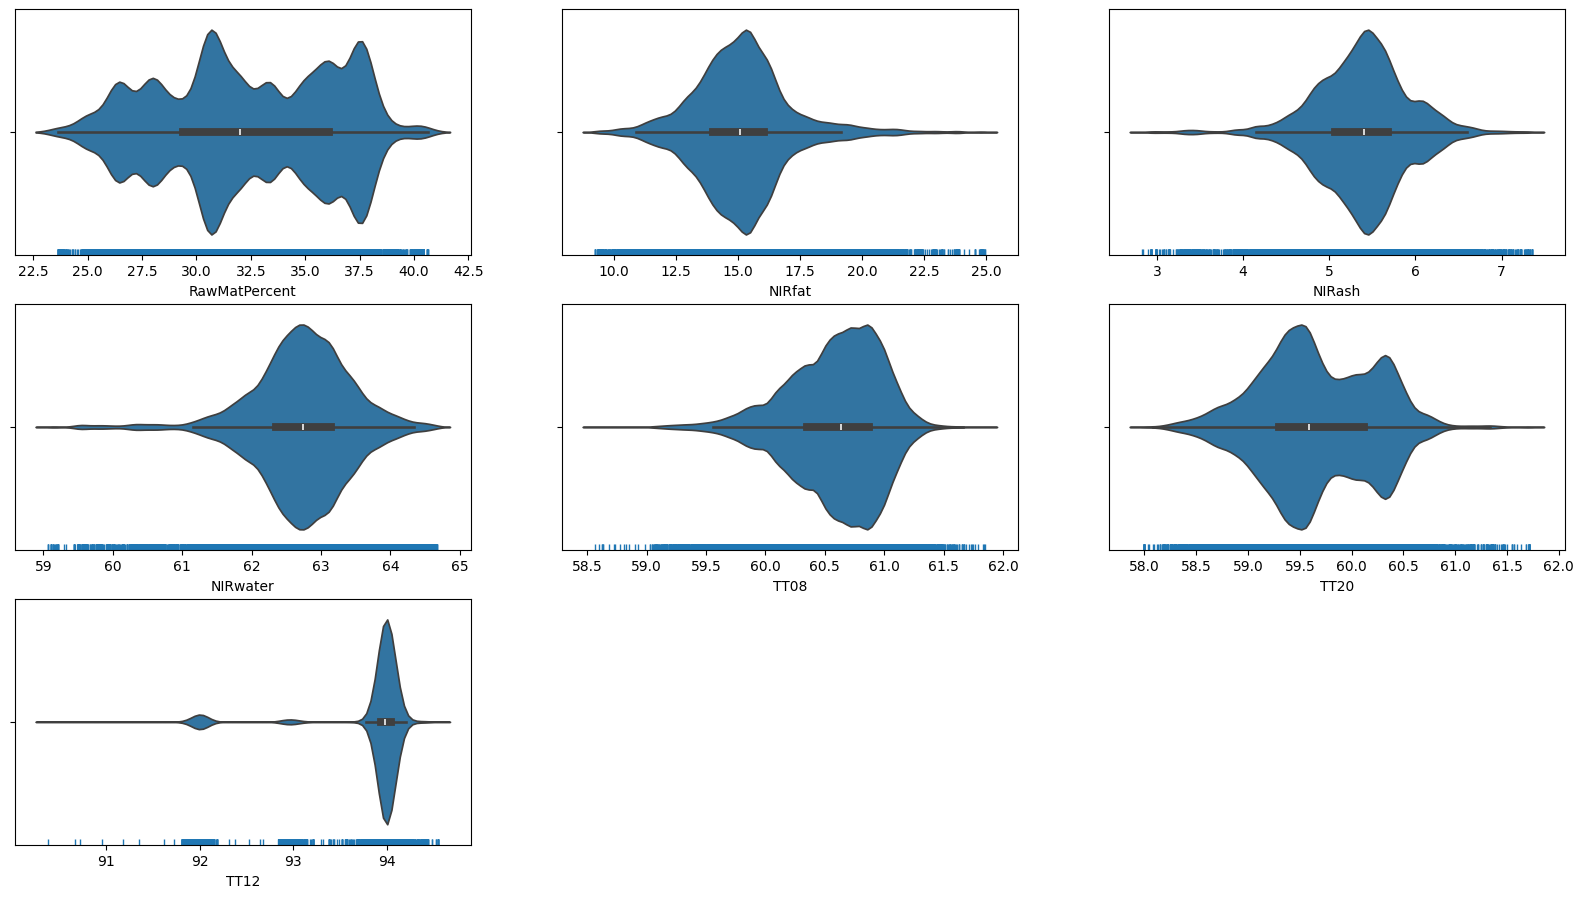

In [17]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(prediktor_data_ekstrem.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), prediktor_data_ekstrem):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = prediktor_data_ekstrem)
  sns.rugplot(x=prediktor_data_ekstrem[indeks])
  i += 1

Informasjon om hele datasett ekskludert ekstrem data

In [18]:
# Ekskluderer ektreme observasjoner fra behandlet data
behandlet_data_ekstrem = behandlet_data.loc[prediktor_data_ekstrem.index]

# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(behandlet_data_ekstrem.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28973 entries, 2022-10-31 17:37:00 to 2023-06-14 01:02:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   28973 non-null  int64  
 1   EnzymeType_A2   28973 non-null  int64  
 2   EnzymeType_B    28973 non-null  int64  
 3   EnzymeType_C    28973 non-null  int64  
 4   EnzymeType_D    28973 non-null  int64  
 5   EnzymeType_E    28973 non-null  int64  
 6   RawMatPercent   28973 non-null  float64
 7   NIRfat          28973 non-null  float64
 8   NIRash          28973 non-null  float64
 9   NIRwater        28973 non-null  float64
 10  TT08            28973 non-null  float64
 11  TT20            28973 non-null  float64
 12  TT12            28973 non-null  float64
 13  Collagen        85 non-null     float64
 14  Mw              452 non-null    float64
 15  SmallMolecules  452 non-null    float64
 16  BrixAdjuste

# Undersøkelse av ekstrem data

Undersøker de ekstreme observasjonene

In [19]:
# Filtrerer ut ekstrem data
ekstrem_data =  behandlet_data.drop(behandlet_data_ekstrem.index)

# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(ekstrem_data.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163 entries, 2022-11-02 10:50:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   163 non-null    int64  
 1   EnzymeType_A2   163 non-null    int64  
 2   EnzymeType_B    163 non-null    int64  
 3   EnzymeType_C    163 non-null    int64  
 4   EnzymeType_D    163 non-null    int64  
 5   EnzymeType_E    163 non-null    int64  
 6   RawMatPercent   163 non-null    float64
 7   NIRfat          163 non-null    float64
 8   NIRash          163 non-null    float64
 9   NIRwater        163 non-null    float64
 10  TT08            163 non-null    float64
 11  TT20            163 non-null    float64
 12  TT12            163 non-null    float64
 13  Collagen        4 non-null      float64
 14  Mw              8 non-null      float64
 15  SmallMolecules  8 non-null      float64
 16  BrixAdjusted 

Violin plot

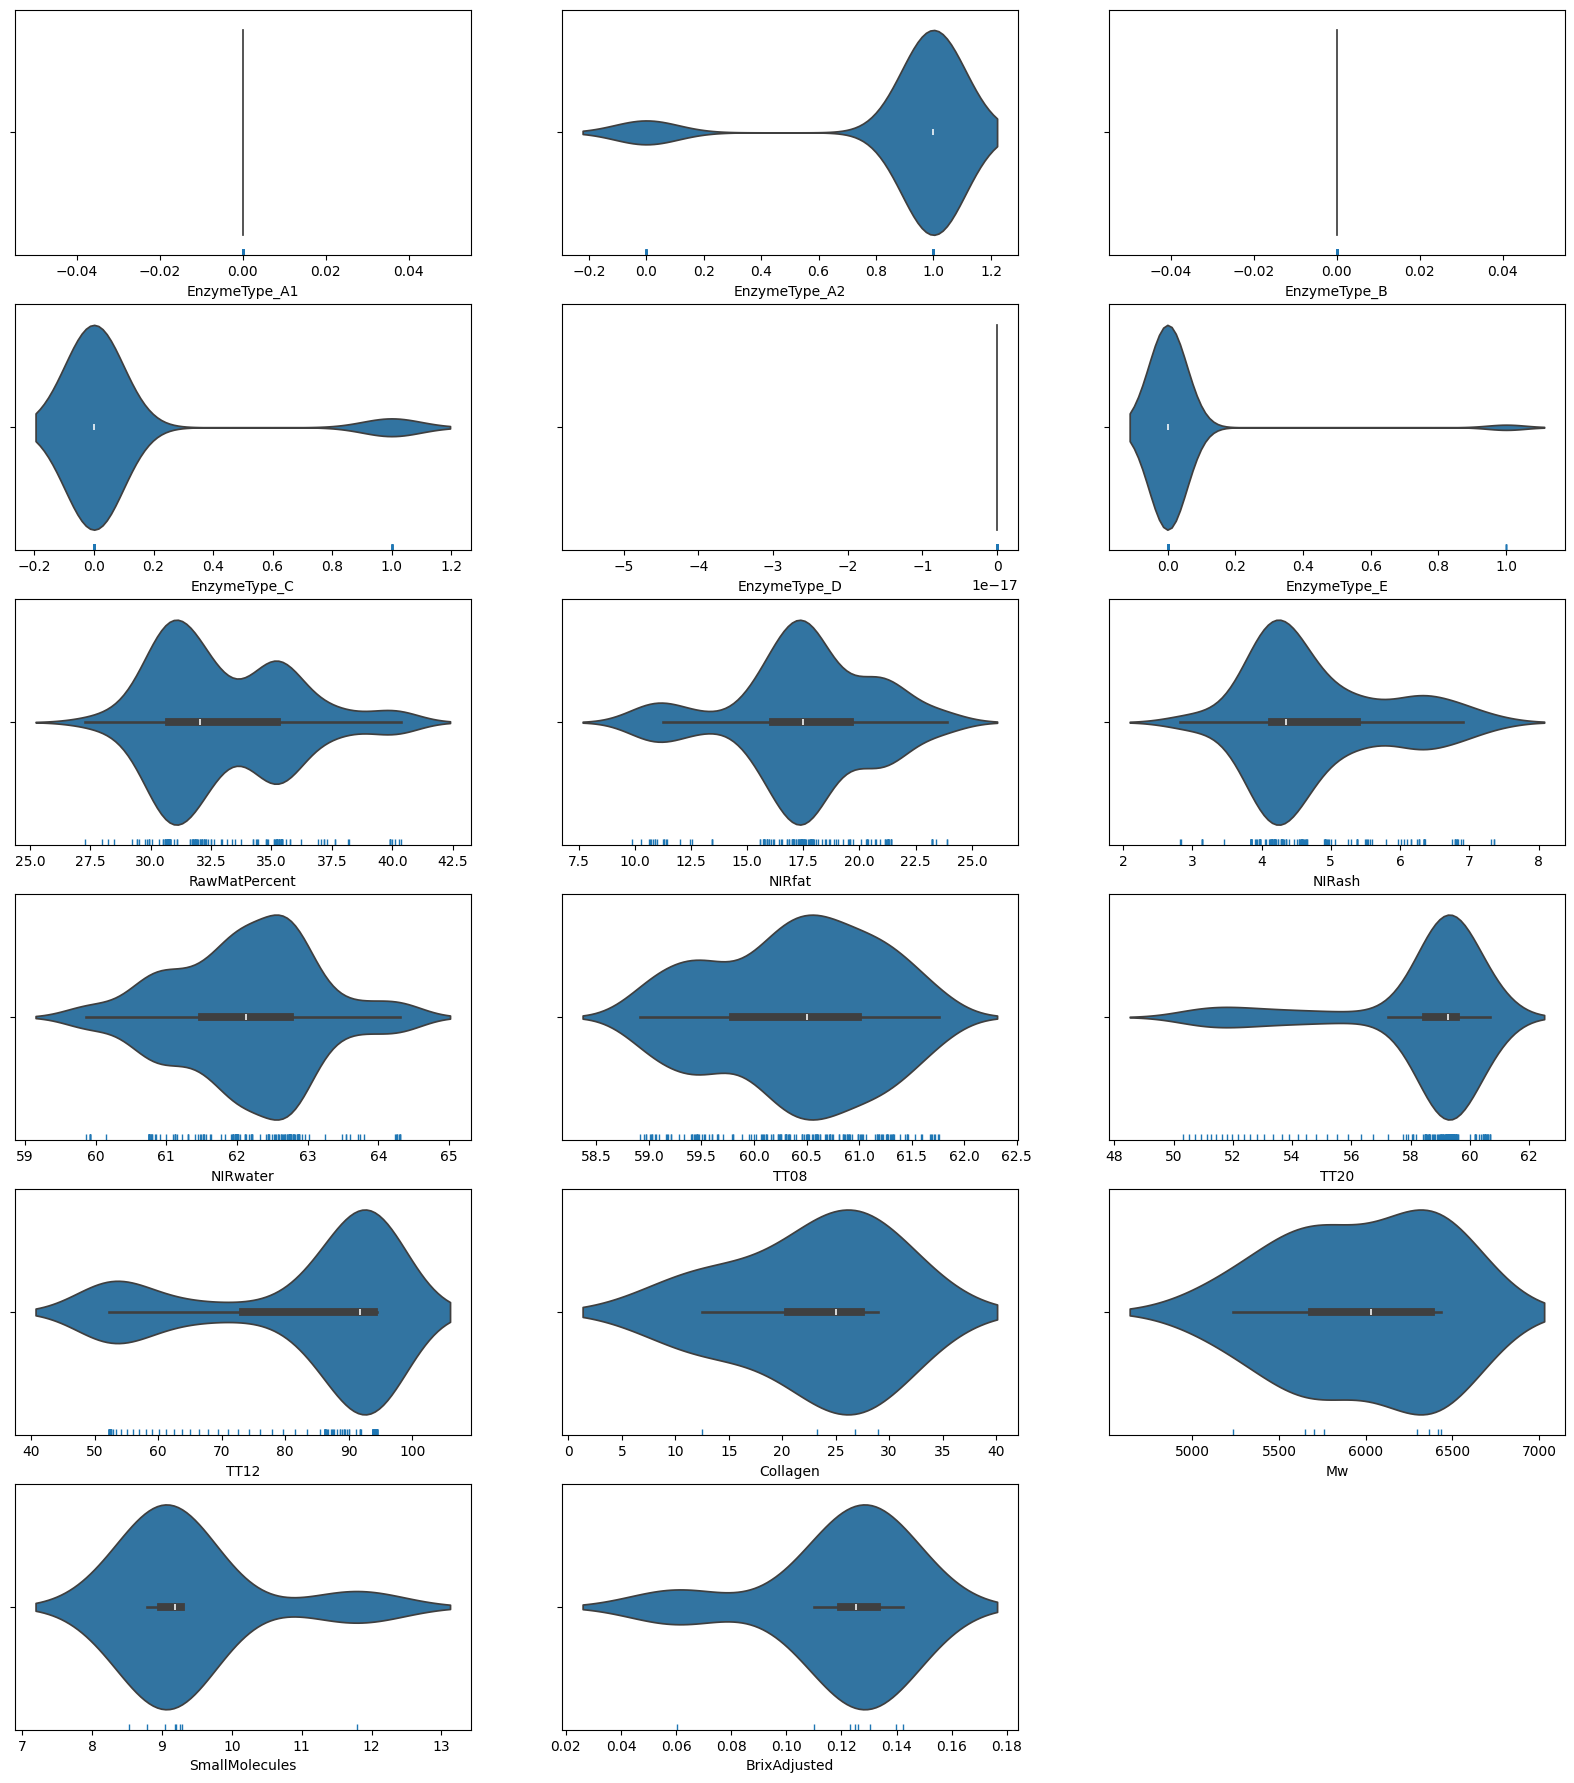

In [20]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(ekstrem_data.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), ekstrem_data):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = ekstrem_data)
  sns.rugplot(x=ekstrem_data[indeks])
  i += 1

Undersøker data for "TT20" i [58, 62] "TT12" i [92, 94] (Kjent informasjon)

In [21]:
ekstrem_data_filtrert = ekstrem_data[(ekstrem_data['TT20'] >= 58) &\
                                     (ekstrem_data['TT20'] <= 62) &\
                                     (ekstrem_data['TT12'] >= 92) &\
                                     (ekstrem_data['TT12'] < 95)]
ekstrem_data_filtrert.shape

(77, 17)

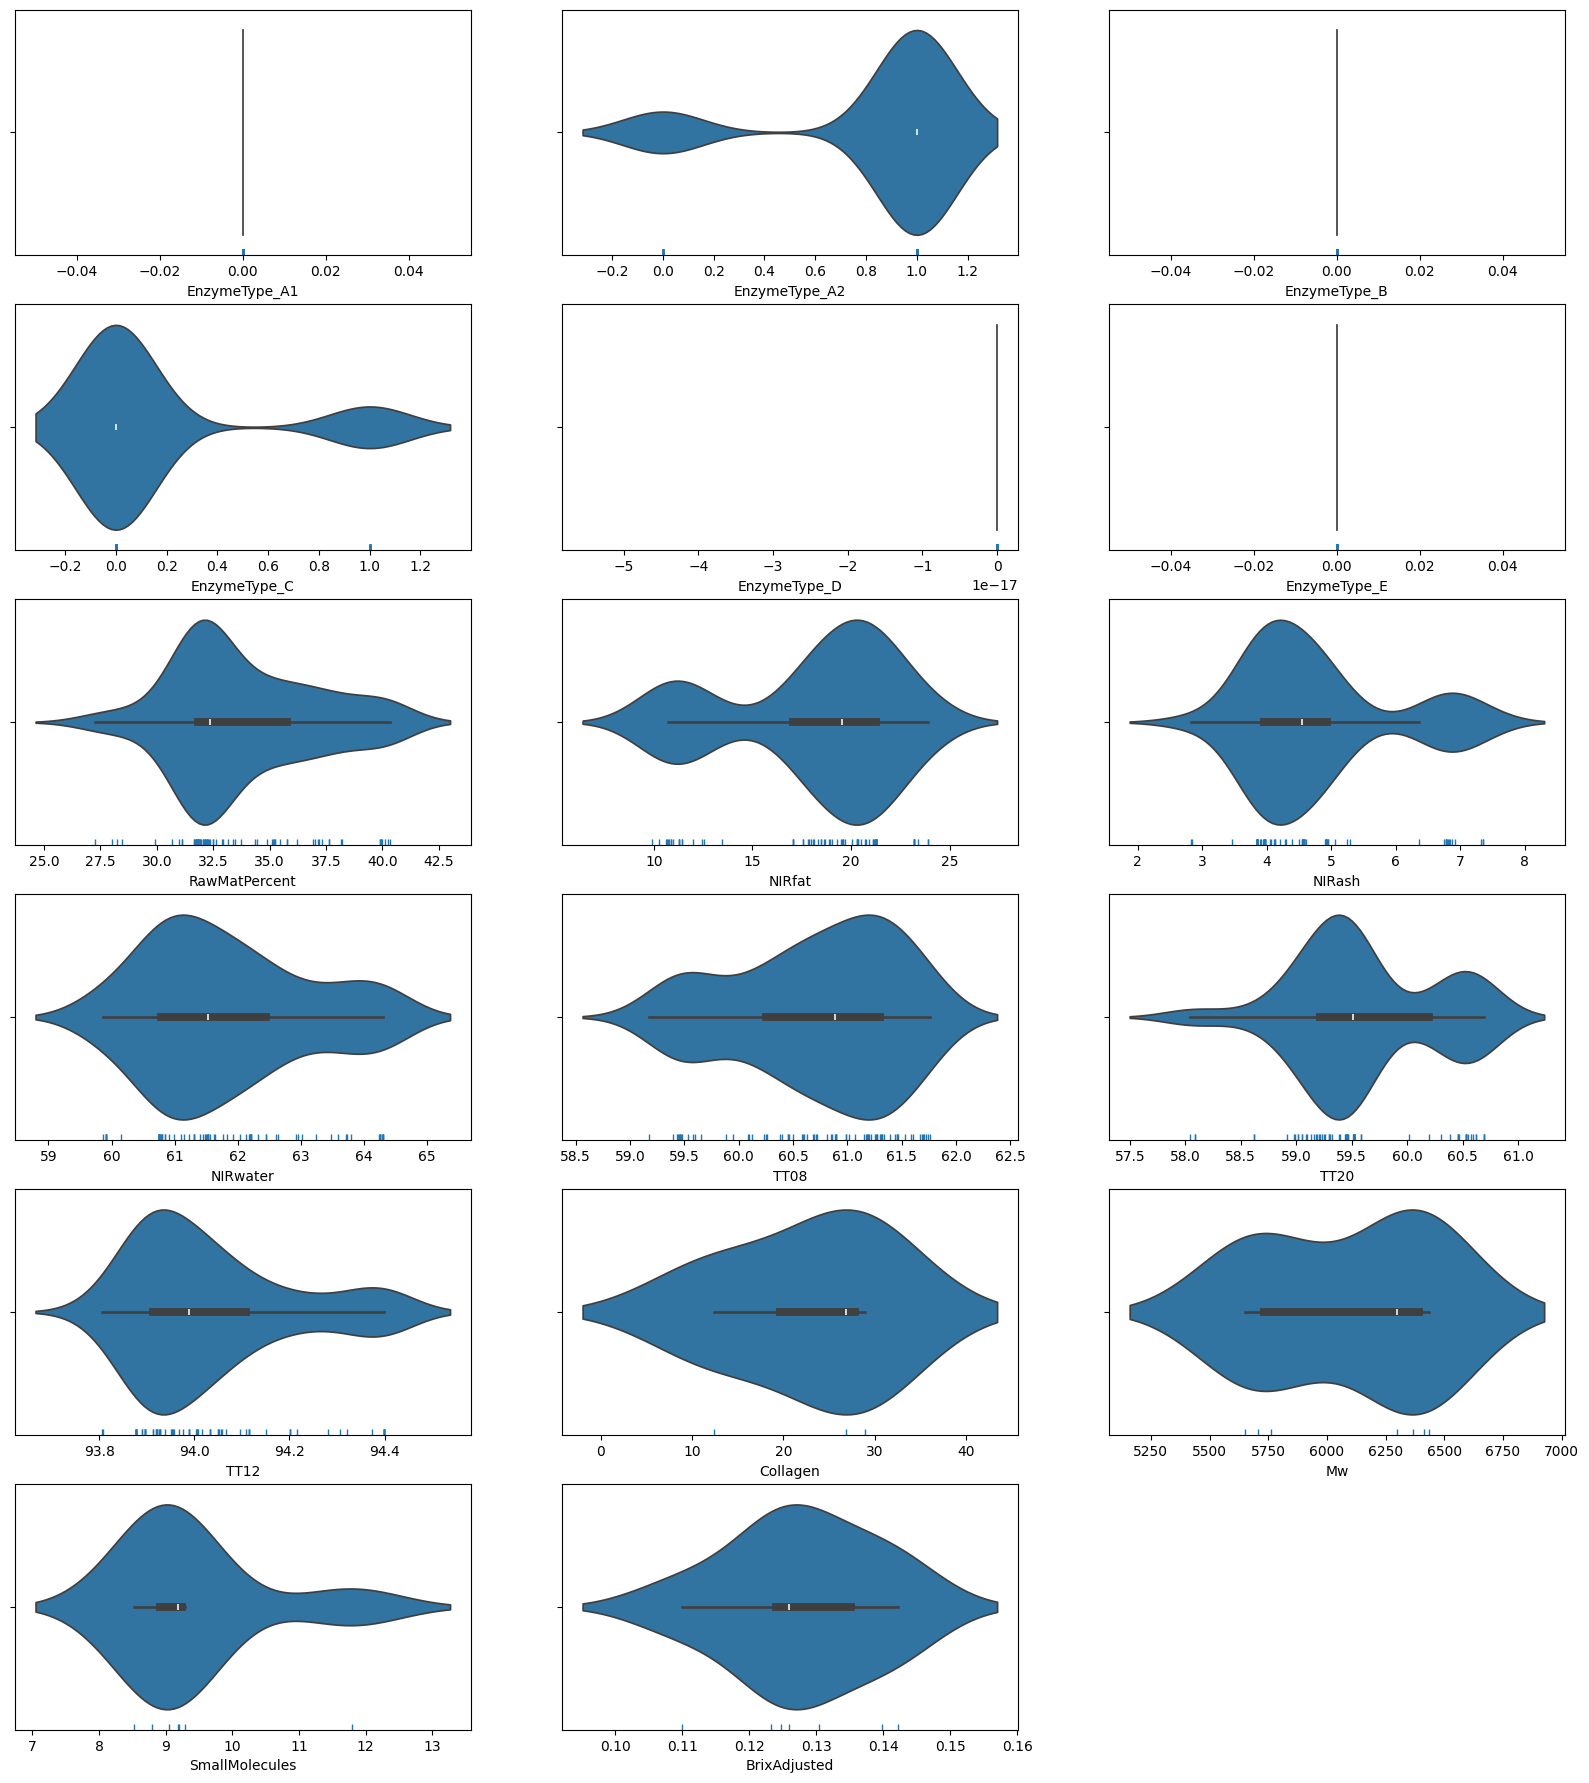

In [22]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(ekstrem_data_filtrert.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), ekstrem_data_filtrert):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = ekstrem_data_filtrert)
  sns.rugplot(x=ekstrem_data_filtrert[indeks])
  i += 1

Undersøker markert data fra det filtrerte datasette med ekstrem data

In [23]:
# Filtrerer ut markert data fra ekstrem data filtrert
ekstrem_markert = ekstrem_data_filtrert.dropna(subset=['Mw'])
ekstrem_markert

,EnzymeType_A1,EnzymeType_A2,EnzymeType_B,EnzymeType_C,EnzymeType_D,EnzymeType_E,RawMatPercent,NIRfat,NIRash,NIRwater,TT08,TT20,TT12,Collagen,Mw,SmallMolecules,BrixAdjusted
sampleID,,,,,,,,,,,,,,,,,
2022-11-08 09:10:00,0,0,0,1,0,0,37.309388,9.890575,6.843597,64.237426,59.47852,59.446620,93.927085,12.45,6367.759861,11.793522,0.109892
2022-12-13 09:40:00,0,1,0,0,0,0,32.054761,19.475465,4.579760,62.043946,61.26345,59.321055,94.398000,NaN,6414.969666,9.197097,0.124786
2022-12-13 09:45:00,0,1,0,0,0,0,31.639288,20.073750,4.505190,61.406672,61.58897,59.520060,94.149885,NaN,6433.265780,8.521806,0.123264
2022-12-13 09:55:00,0,1,0,0,0,0,31.774826,21.250747,3.851002,60.754326,61.38824,59.520060,93.889110,28.98,6298.379432,8.787621,0.125886
2022-12-13 10:00:00,0,1,0,0,0,0,32.207659,21.250747,3.851002,60.754326,60.81315,59.306835,93.876450,26.81,5761.500503,9.044750,0.130404
2022-12-13 10:05:00,0,1,0,0,0,0,32.898636,21.250747,3.851002,60.794752,60.46050,59.136265,93.876450,NaN,5652.275321,9.190380,0.139823
2022-12-13 10:10:00,0,1,0,0,0,0,33.751545,20.329135,4.048187,61.492496,60.23264,58.975170,93.924555,NaN,5704.743362,9.287835,0.142216


In [24]:
# NIRfat <10 ansett som ekstrem observasjon, filtrerer dem bort
ekstrem_markert_filtrert = ekstrem_markert[(ekstrem_markert['NIRfat'] >= 10)]
ekstrem_markert_filtrert.shape[0]

6

In [25]:
# NIRash <4 ansett som ekstrem observasjon, filtrer dem bort
ekstrem_markert_filtrert = ekstrem_markert_filtrert[(ekstrem_markert_filtrert['NIRash'] >= 4)]
ekstrem_markert_filtrert.shape[0]

3

In [31]:
# Sjekker gjenværende markerte observasjoner etter manuelle filtreringer
ekstrem_markert_filtrert

,EnzymeType_A1,EnzymeType_A2,EnzymeType_B,EnzymeType_C,EnzymeType_D,EnzymeType_E,RawMatPercent,NIRfat,NIRash,NIRwater,TT08,TT20,TT12,Collagen,Mw,SmallMolecules,BrixAdjusted
sampleID,,,,,,,,,,,,,,,,,
2022-12-13 09:40:00,0,1,0,0,0,0,32.054761,19.475465,4.579760,62.043946,61.26345,59.321055,94.398000,NaN,6414.969666,9.197097,0.124786
2022-12-13 09:45:00,0,1,0,0,0,0,31.639288,20.073750,4.505190,61.406672,61.58897,59.520060,94.149885,NaN,6433.265780,8.521806,0.123264
2022-12-13 10:10:00,0,1,0,0,0,0,33.751545,20.329135,4.048187,61.492496,60.23264,58.975170,93.924555,NaN,5704.743362,9.287835,0.142216


Legger til ekstrem_data_markert data ansett som ekstrem data tilbake til datasett

In [27]:
behandlet_data_ekstrem = pd.concat([behandlet_data_ekstrem, ekstrem_markert_filtrert], axis=0)
behandlet_data_ekstrem = behandlet_data_ekstrem.sort_index(ascending=True)

Undersøker markert data som ikke blir inkludert

In [32]:
# Filtrerer ut ekstrem data
ekstrem_data =  behandlet_data.drop(behandlet_data_ekstrem.index)

# Filtrerer ut markert data fra ekstrem data filtrert
ekstrem_markert = ekstrem_data.dropna(subset=['Mw'])
ekstrem_markert

,EnzymeType_A1,EnzymeType_A2,EnzymeType_B,EnzymeType_C,EnzymeType_D,EnzymeType_E,RawMatPercent,NIRfat,NIRash,NIRwater,TT08,TT20,TT12,Collagen,Mw,SmallMolecules,BrixAdjusted
sampleID,,,,,,,,,,,,,,,,,
2022-11-08 09:10:00,0,0,0,1,0,0,37.309388,9.890575,6.843597,64.237426,59.47852,59.446620,93.927085,12.45,6367.759861,11.793522,0.109892
2022-12-01 12:50:00,0,1,0,0,0,0,34.801911,17.842532,5.381879,62.006226,60.52561,59.332900,86.508825,23.29,5235.432713,9.264557,0.060342
2022-12-13 09:55:00,0,1,0,0,0,0,31.774826,21.250747,3.851002,60.754326,61.38824,59.520060,93.889110,28.98,6298.379432,8.787621,0.125886
2022-12-13 10:00:00,0,1,0,0,0,0,32.207659,21.250747,3.851002,60.754326,60.81315,59.306835,93.876450,26.81,5761.500503,9.044750,0.130404
2022-12-13 10:05:00,0,1,0,0,0,0,32.898636,21.250747,3.851002,60.794752,60.46050,59.136265,93.876450,NaN,5652.275321,9.190380,0.139823


# Lagring av data behandlet for ekstreme verdier som csv

In [29]:
behandlet_data_ekstrem.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28976 entries, 2022-10-31 17:37:00 to 2023-06-14 01:02:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   28976 non-null  int64  
 1   EnzymeType_A2   28976 non-null  int64  
 2   EnzymeType_B    28976 non-null  int64  
 3   EnzymeType_C    28976 non-null  int64  
 4   EnzymeType_D    28976 non-null  int64  
 5   EnzymeType_E    28976 non-null  int64  
 6   RawMatPercent   28976 non-null  float64
 7   NIRfat          28976 non-null  float64
 8   NIRash          28976 non-null  float64
 9   NIRwater        28976 non-null  float64
 10  TT08            28976 non-null  float64
 11  TT20            28976 non-null  float64
 12  TT12            28976 non-null  float64
 13  Collagen        85 non-null     float64
 14  Mw              455 non-null    float64
 15  SmallMolecules  455 non-null    float64
 16  BrixAdjusted    455 non-null    float64
d

In [30]:
behandlet_data_ekstrem.to_csv('/content/drive/MyDrive/MasterV24/Bioco_data/ekstremverdi_data_behandlet_bioco_data.csv')